<a href="https://colab.research.google.com/github/22anirudhk/gum-disease-recognition/blob/master/CNN_Synopsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount("/content/drive")

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
from tensorflow.keras.callbacks import TensorBoard

#NAME IS AT THE .train cell

import zipfile

#ALL
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Synopsys/All_Diseased.zip", 'r')
zip_ref.extractall("/content/Synopsys/CNN-Images") 
zip_ref.close()


zip_ref = zipfile.ZipFile("/content/drive/My Drive/Synopsys/All_healthy.zip", 'r')
zip_ref.extractall("/content/Synopsys/CNN-Images") 
zip_ref.close()


#HALF
# zip_ref = zipfile.ZipFile("/content/drive/My Drive/Synopsys/half_diseased.zip", 'r')
# zip_ref.extractall("/content/Synopsys/CNN-Images") 
# zip_ref.close()


# zip_ref = zipfile.ZipFile("/content/drive/My Drive/Synopsys/half_healthy.zip", 'r')
# zip_ref.extractall("/content/Synopsys/CNN-Images") 
# zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


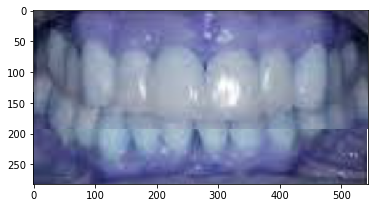

In [0]:
#Get images and resize
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

DATADIR = "/content/Synopsys/CNN-Images"
Categories = ['All_Diseased', 'All_healthy']

training_data = []

def create_training_data() :
  counter = 0
  NUM_IMAGES_TO_SHOW = 0

  for category in Categories:
     path = os.path.join(DATADIR, category) #connect the datadirectory to the index in category
     class_num = Categories.index(category) #0 for diseased
     for img in os.listdir(path):
       img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
       try:
         plt.imshow(img_array)
         #plt.show()
         IMG_WIDTH = 250 #So 20,000 pixels
         IMG_LENGTH = 500
         new_array = cv2.resize(img_array, (IMG_WIDTH, IMG_LENGTH))
         training_data.append([new_array, class_num])
       except Exception as e:
         pass
       if(counter < NUM_IMAGES_TO_SHOW):
         plt.show()
       counter += 1

create_training_data()




#randomize image set
import random
random.shuffle(training_data)

In [0]:
#package images for neural net
X = []
y = []

for features,label in training_data:
  X.append(features)
  y.append(label)

X = np.array(X)
y = np.array(y)


#X = X.reshape(-1, IMG_WIDTH, IMG_LENGTH, 1) #-1 connects to how many features you have
#THIS CAUSED A PROBLEM for the dimensions

#Open the pickle
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [0]:
#open the images
import pickle
from tensorflow.keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import time



#Creates the CNN model
def make_model():
    
  #Name and tensorboard

  NAME = "Disease-Identifer-cnn-64x3-{}".format(int(time.time())) #Store the model with a time

  # !pip install tensorboardcolab
  # from tensorboardcolab import * 
  # tbc = TensorBoardColab() # To create a tensorboardcolab object it will automatically creat a link
  # writer = tbc.get_writer() # To create a FileWriter
  # writer.add_graph(tf.get_default_graph()) # add the graph 
  # writer.flush() 
 

  #Load the images

  X = pickle.load(open("X.pickle", "rb"))
  y = pickle.load(open("y.pickle", "rb"))


  # X[:] = [value / 255.0 for value in X]


  #Add first layer
  model = Sequential() 
  model.add(Conv2D(64, (2,2), input_shape = X.shape[1:])) #3,3 is the size of the convolution #2,2 is strieds
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size = (2,2)))


  #Add second layer
  model = Sequential() 
  model.add(Conv2D(64, (2,2))) #2,2 is conv check layer
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size = (2,2)))


  #Last layer that has 1d version of the data from the 2,2 convolutional layers
  model.add(Flatten()) #converts 3d maps to 1d vectors
  model.add(Dense(64))
  model.add(Activation("relu"))

  #Add last layer
  model.add(Dense(1))
  model.add(Activation("sigmoid"))

  model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy']) #can do loss = "category" later
  #adam is a special optimizer

  #print(X.dtype)
  #D(ata)TYPE OF X WAS WRONG

  #Get best model:
  best_weights_filepath = '/content/Synopsys/best_weights.hdf5'

  #Verbose just means you want it to print how it's going
  saveBestModel = ModelCheckpoint(best_weights_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

  model.fit(np.float64(X), np.float64(y), epochs = 10, batch_size = 32, validation_split = 0.05, shuffle=True, callbacks=[saveBestModel]) #, callbacks=[TensorBoardColabCallback(tbc)]
  #can even pass epochs = "" as parameter

  model.load_weights(best_weights_filepath)

  return model


myModel = make_model()


# import cv2
# import tensorflow as tf

# categs = ["Diseased_Testing", "Healthy_Testing"]

# def setup(filepath):
#   IMG_WIDTH = 250
#   IMG_LENGTH = 500
#   img_arr = cv2.imread(filepath, cv2.IMREAD_COLOR)
#   new_arr = cv2.resize(img_arr, (IMG_WIDTH, IMG_HEIGHT))
#   return new_arr.reshape(-1, IMG_WIDTH, IMG_LENGTH)



Train on 2018 samples, validate on 107 samples
Epoch 1/10
2016/2018 [============================>.] - ETA: 0s - loss: 2069.4860 - acc: 0.6200
Epoch 00001: val_acc improved from -inf to 0.90654, saving model to /content/Synopsys/best_weights.hdf5
2018/2018 [==============================] - 49s 24ms/sample - loss: 2067.4350 - acc: 0.6204 - val_loss: 23.7211 - val_acc: 0.9065
Epoch 2/10
2016/2018 [============================>.] - ETA: 0s - loss: 26.6154 - acc: 0.8676
Epoch 00002: val_acc did not improve from 0.90654
2018/2018 [==============================] - 41s 20ms/sample - loss: 26.5890 - acc: 0.8677 - val_loss: 14.8426 - val_acc: 0.8972
Epoch 3/10
2016/2018 [============================>.] - ETA: 0s - loss: 12.8020 - acc: 0.9201
Epoch 00003: val_acc did not improve from 0.90654
2018/2018 [==============================] - 40s 20ms/sample - loss: 12.7893 - acc: 0.9202 - val_loss: 14.0669 - val_acc: 0.8224
Epoch 4/10
2016/2018 [============================>.] - ETA: 0s - loss: 10.8

In [0]:
# myModel.save("/content/Synopsys/CNN-Images/two-layer_relu_64_2x2.model")

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import os
import cv2
import zipfile


init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

model = tf.keras.models.load_model('/content/Synopsys/two-layer_relu_64_2x2.model')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Synopsys/Diseased_Testing.zip", 'r')
zip_ref.extractall("/content/Synopsys/CNN-Images") 
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Synopsys/Healthy_Testing.zip", 'r')
zip_ref.extractall("/content/Synopsys/CNN-Images") 
zip_ref.close()

#You could additionally resize and scale images before tseting

def prepare(filepath):
  img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
  IMG_WIDTH = 250 #So 20,000 pixels
  IMG_LENGTH = 500
  new_array = cv2.resize(img_array, (IMG_WIDTH, IMG_LENGTH))
  return np.array(new_array).reshape(-1, IMG_WIDTH, IMG_LENGTH, 1)

num_diseased_correct = 0
num_healthy_correct = 0

#Go through all diseased images
for filename in os.listdir('/content/Synopsys/CNN-Images/Diseased_Testing'):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".img"): 
      # image_list = []
      # image_list.append("/content/Synopsys/CNN-Images/Diseased_Testing/"+filename)
      # image_list = np.array(image_list)
      # if (model.predict(image_list)[0][0]) == 0:
      #   num_diseased_correct += 1
      # model.predict([prepare("/content/Synopsys/CNN-Images/Diseased_Testing/"+ filename)])

#Go through all healthy images
for filename in os.listdir('/content/Synopsys/CNN-Images/Healthy_Testing'):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".img"): 
      # image_list = []
      # image_list.append("/content/Synopsys/CNN-Images/Healthy_Testing/"+filename)
      # image_list = np.array(image_list)
      # if (model.predict(image_list)[0][0]) == 0:
      #   num_diseased_correct += 1
      
      # model.predict([prepare("/content/Synopsys/CNN-Images/Diseased_Testing/"+ filename)])

print(num_diseased_correct)
print(num_healthy_correct)

# pickle_out = open("testingX.pickle", "wb")
# pickle.dump(testingX, pickle_out)
# pickle_out.close()

# pickle_out = open("testingy.pickle", "wb")
# pickle.dump(testingy, pickle_out)
# pickle_out.close()

# xPick = pickle.load(open("testingX.pickle", "rb"))
# yPick = pickle.load(open("testingy.pickle", "rb"))




ValueError: ignored

In [0]:


#Done this already